## Load packages

In [1]:
# Loading libraries
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations
from skimage import io, measure               # Module from skimage
from skimage.filters import gaussian # Module working with a gaussian filter
import os
%matplotlib inline

from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import difference_of_gaussians
from cellpose import plot, models
from skimage.morphology import remove_small_objects

## Preprocessing

In [73]:
img_0 = []
for i in range(6):
    figName = './NoDrug/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_0.append(img)
    figName = './NoDrug/rep2_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_0.append(img)

img_3 = []
for i in range(6):
    figName = './Drug3_1000nM/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_3.append(img)
    figName = './Drug3_1000nM/rep2_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_3.append(img)

img_4 = []
for i in range(6):
    figName = './Drug4_1000nM/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_4.append(img)
    figName = './Drug4_1000nM/rep2_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_4.append(img)

img_5 = []
for i in range(6):
    figName = './Drug5_1000nM/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_5.append(img)
    figName = './Drug5_1000nM/rep2_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_5.append(img)

img_6 = []
for i in range(6):
    figName = './Drug6_1000nM/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_6.append(img)
    figName = './Drug6_1000nM/rep2_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_6.append(img)

## Get all dataframe for one video

In [37]:
def get_all(img, diameter_nuc=80, diameter_cyto=100, threshold_spots=0.05, threshold_site=0.35):
    img_nuc = img[0,:,:,0]
    model = models.Cellpose(model_type='nuclei')
    masks_nuc  = model.eval(img_nuc, diameter=diameter_nuc, channels=[0,1])[0]
    masks_nuc = remove_small_objects(masks_nuc, min_size=50)

    img_cyto = img[0,:,:,1]
    model = models.Cellpose(model_type='cyto')
    masks_cyto = model.eval(img_cyto, diameter=diameter_cyto, channels=[0,2])[0]

    nucleus_indices = np.zeros(np.max(masks_cyto)+1, dtype=int)
    nucleus_center = []
    for i in range(1,np.max(masks_nuc)+1):
        posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
        nucleus_center.append(posn_nucl)
        nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

    number_detected_cells = np.max([masks_nuc,masks_cyto])

    list_cyt_areas = []
    list_nuc_areas = []
    for i in range (1,number_detected_cells+1):
        selected_cyto_mask = (masks_cyto==i)
        area_cyto = np.sum(selected_cyto_mask)
        list_cyt_areas.append(area_cyto)
        
        selected_nuc_mask = (masks_nuc==nucleus_indices[i])
        area_nuc = np.sum(selected_nuc_mask)
        list_nuc_areas.append(area_nuc)

    print('Nucleus and cytoplast masks and areas done!')
    df = pd.DataFrame(list(range(1,number_detected_cells+1)), columns=['cell index'])
    df['nucleus area'] = np.array(list_nuc_areas).astype(int)
    df['cytosol area'] = np.array(list_cyt_areas).astype(int)

    is_vital = [True for _ in range(number_detected_cells)]
    cyt_intensities = np.zeros((number_detected_cells,img.shape[0]))
    nuclear_particles = np.zeros((number_detected_cells,img.shape[0]))
    cytosol_particles = np.zeros((number_detected_cells,img.shape[0]))

    for t in range(img.shape[0]):
        print(f'current time: {t}')

        img_nuc = img[t,:,:,0]
        masks_nuc_new  = model.eval(img_nuc, diameter=diameter_nuc, channels=[0,1])[0]
        for i in range(number_detected_cells):
            i = nucleus_indices[i]
            if is_vital[i] == True:
                center = nucleus_center[i]
                if masks_nuc_new[center[0],center[1]] == 0:
                    is_vital[i] = False
        print(f'Vitality done!')
        
        img_cyto = img[t,:,:,1]
        list_cyt_intensities = np.zeros(number_detected_cells)
        for i in range (1,number_detected_cells+1):
            if is_vital[i-1]:
                selected_cyto_mask = (masks_cyto==i)
                selected_color_image = selected_cyto_mask*img_cyto
                selected_color_image_nonzero = selected_color_image[np.nonzero(selected_color_image)]
                if selected_color_image_nonzero.size >0:
                    list_cyt_intensities[i-1] = (selected_color_image_nonzero.mean())
            else:
                list_cyt_intensities[i-1] = 0
        cyt_intensities[:,t] = list_cyt_intensities
        print('Protein intensities done!')

        ### mRNA pre-processing
        img_spots = img[t,:,:,2]
        img_spots_filtered = difference_of_gaussians(img_spots, low_sigma=1, high_sigma=5)
        img_spots_binary = img_spots_filtered.copy()
        img_spots_binary[img_spots_binary<threshold_spots] = 0 # Making spots below the threshold equal to 0.
        img_spots_binary[img_spots_binary>=threshold_spots] = 1 # Making spots above the threshold equal to the threshold value.
        spot_contours = measure.find_contours(img_spots_binary, 0.5)

        ### counting mRNA particles
        list_cytosol_particles = np.zeros(number_detected_cells)
        list_nuclear_particles = np.zeros(number_detected_cells)
        for i in range(len(spot_contours)):
            posn = np.mean(spot_contours[i], axis=0).astype(int)
            cell_num_nuc = masks_nuc[posn[0], posn[1]]
            cell_num_cyto = masks_cyto[posn[0], posn[1]]
            if cell_num_nuc>0:
                if is_vital[nucleus_indices[cell_num_nuc]-1]:
                    list_nuclear_particles[nucleus_indices[cell_num_nuc]-1] += 1
            elif cell_num_cyto>0:
                if is_vital[cell_num_cyto-1]:
                    list_cytosol_particles[cell_num_cyto-1] += 1
        nuclear_particles[:,t] = list_nuclear_particles
        cytosol_particles[:,t] = list_cytosol_particles
        print('Number of mRNA done!')
       
    df[f'protein intensity'] = [cyt_intensities[i,:].astype(float) for i in range(number_detected_cells)]
    df[f'mRNA in cytosol'] = [cytosol_particles[i,:].astype(int) for i in range(number_detected_cells)]
    df[f'mRNA in nucleus'] = [nuclear_particles[i,:].astype(int) for i in range(number_detected_cells)]
    df.insert(1, 'cell vitality', is_vital)

    ### site pre-processing
    img_site = np.max(img[:,:,:,2], axis=0)
    img_sites_filtered = difference_of_gaussians(img_site, low_sigma=1, high_sigma=5)
    img_sites_binary = img_sites_filtered.copy()
    img_sites_binary[img_sites_binary<threshold_site] = 0 # Making spots below the threshold equal to 0.
    img_sites_binary[img_sites_binary>=threshold_site] = 1 # Making spots above the threshold equal to the threshold value.
    site_contours = measure.find_contours(img_sites_binary, 0.5)

    ### counting sites
    list_site_particles = np.zeros(number_detected_cells)
    for i in range(len(site_contours)):
        # Find the position of the particle
        posn = np.mean(site_contours[i], axis=0).astype(int)

        # Check which cyto mask is the particle in
        cell_num = masks_nuc[posn[0], posn[1]]
        if cell_num>0:
            list_site_particles[nucleus_indices[cell_num]-1] += 1
    print('Number of site done!')

    ### site intensities
    list_site_intensities = np.zeros(number_detected_cells)
    list_site_intensities_1 = np.zeros(number_detected_cells)
    list_site_intensities_2 = np.zeros(number_detected_cells)

    selected_mask = (img_sites_filtered > 0)
    for i in range (1, number_detected_cells+1):
        selected_nuc_mask = (masks_nuc == i)
        selected_color_image = selected_mask*selected_nuc_mask*img_spots
        selected_nonzero = selected_color_image[np.nonzero(selected_color_image)]
        if selected_nonzero.size > 0:
            list_site_intensities[nucleus_indices[i]-1] = selected_nonzero.mean()
            list_site_intensities_1[nucleus_indices[i]-1] = np.max(selected_nonzero)
            list_site_intensities_2[nucleus_indices[i]-1] = np.partition(selected_nonzero,-2)[-2]
    print('Site intensities done!')
    
    df['site mean intensity'] = list_site_intensities
    df['site 1st intensity'] = list_site_intensities_1
    df['site 2nd intensity'] = list_site_intensities_2

    print('Summary of dataframe done!')

    return df

In [5]:
img = img_0[0]
df = get_all(img)

Nucleus and cytoplast masks and areas done!
current time: 0
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 1
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 2
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 3
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 4
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 5
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 6
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 7
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 8
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 9
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 10
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 11
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 12
V

In [6]:
df

,cell index,cell vitality,nucleus area,cytosol area,protein intensity,mRNA in cytosol,mRNA in nucleus,site mean intensity,site 1st intensity,site 2nd intensity
0,1,True,2748,8158,"[81.34383427310615, 81.4485167933317, 88.55626...","[6, 4, 7, 14, 12, 13, 18, 17, 15, 15, 17, 15, ...","[3, 5, 6, 3, 5, 7, 5, 3, 4, 9, 8, 5, 3, 7, 9, ...",29.734735,36.0,35.0
1,2,True,2769,9572,"[63.891245298788135, 62.46991224404513, 62.892...","[0, 0, 0, 1, 4, 6, 4, 3, 3, 2, 2, 4, 1, 1, 1, ...","[0, 1, 2, 2, 5, 3, 2, 0, 0, 1, 3, 2, 2, 0, 0, ...",30.346535,35.0,35.0
2,3,True,2830,9944,"[121.76106194690266, 128.9320193081255, 132.87...","[15, 16, 10, 9, 5, 9, 11, 11, 7, 8, 7, 7, 5, 3...","[6, 4, 2, 1, 3, 6, 2, 1, 3, 4, 4, 3, 1, 0, 2, ...",30.625123,58.0,58.0
3,4,True,2971,9393,"[88.6466517619504, 85.02288938571276, 81.16767...","[8, 4, 4, 1, 6, 4, 6, 7, 9, 6, 5, 2, 1, 0, 0, ...","[3, 2, 1, 4, 4, 3, 8, 3, 0, 0, 0, 0, 0, 0, 0, ...",34.955961,74.0,74.0
4,5,True,2655,8561,"[109.58754818362341, 104.56955963088424, 95.35...","[9, 6, 3, 5, 4, 5, 5, 2, 1, 6, 5, 6, 9, 10, 3,...","[3, 3, 5, 2, 2, 2, 2, 3, 3, 2, 6, 5, 3, 0, 0, ...",29.460052,35.0,35.0
5,6,True,2959,9947,"[117.72152407761133, 114.49944706946818, 105.1...","[13, 8, 7, 5, 9, 9, 7, 2, 3, 4, 11, 9, 16, 11,...","[2, 1, 3, 2, 3, 2, 2, 3, 2, 7, 6, 4, 2, 3, 3, ...",34.728519,112.0,108.0
6,7,True,2636,8824,"[66.98198096101541, 66.38689936536719, 71.8074...","[0, 2, 5, 5, 5, 3, 2, 1, 0, 0, 1, 3, 6, 8, 10,...","[1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 3, 6, 6, ...",38.841751,99.0,97.0
7,8,True,2568,8986,"[81.62931226352103, 75.26819496995326, 76.9555...","[1, 1, 7, 13, 14, 8, 13, 7, 10, 13, 13, 8, 10,...","[0, 1, 7, 6, 2, 3, 5, 4, 4, 6, 4, 6, 7, 5, 4, ...",48.424539,255.0,255.0
8,9,True,2941,8879,"[77.2875323797725, 73.39058452528438, 70.36986...","[2, 2, 1, 0, 0, 0, 2, 7, 10, 15, 9, 16, 16, 15...","[0, 0, 0, 0, 0, 0, 2, 2, 6, 9, 7, 6, 6, 5, 5, ...",63.723868,255.0,255.0
9,10,True,2756,11206,"[124.43681956094949, 133.01963233981795, 132.0...","[15, 15, 13, 9, 11, 17, 18, 14, 11, 10, 7, 4, ...","[6, 6, 3, 1, 10, 7, 5, 3, 1, 1, 1, 0, 0, 0, 0,...",30.643394,56.0,55.0


## Get only average over vitable cells

In [64]:
def get_average(img, diameter_nuc=100, diameter_cyto=100, threshold_spots=0.05):
    img_nuc = img[0,:,:,0]
    model = models.Cellpose(model_type='nuclei')
    masks_nuc  = model.eval(img_nuc, diameter=diameter_nuc, channels=[0,1])[0]
    masks_nuc = remove_small_objects(masks_nuc, min_size=50)

    img_cyto = img[0,:,:,1]
    model = models.Cellpose(model_type='cyto')
    masks_cyto = model.eval(img_cyto, diameter=diameter_cyto, channels=[0,2])[0]

    nucleus_indices = np.zeros(np.max(masks_cyto)+1,dtype=int)
    nucleus_center = []
    for i in range(1,np.max(masks_nuc)+1):
        posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
        nucleus_center.append(posn_nucl)
        nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

    number_detected_cells = np.max([masks_nuc, masks_cyto])

    is_vital = [True for _ in range(number_detected_cells)]
    vital_number = np.zeros(img.shape[0])
    cyt_intensities = np.zeros(img.shape[0])
    nuclear_particles = np.zeros(img.shape[0])
    cytosol_particles = np.zeros(img.shape[0])

    for t in range(img.shape[0]):
        print(f'current time: {t}')

        img_nuc = img[t,:,:,0]
        masks_nuc_new  = model.eval(img_nuc, diameter=diameter_nuc, channels=[0,1])[0]
        vital_number[t] = np.unique(masks_nuc_new)-1
        print(f'Vitality done!')
        
        img_cyto = img[t,:,:,1]
        list_cyt_intensities = np.zeros(number_detected_cells)
        for i in range (1,number_detected_cells+1):
            if is_vital[i-1]:
                selected_cyto_mask = (masks_cyto==i)
                selected_color_image = selected_cyto_mask*img_cyto
                selected_color_image_nonzero = selected_color_image[np.nonzero(selected_color_image)]
                if selected_color_image_nonzero.size > 0:
                    list_cyt_intensities[i-1] = (selected_color_image_nonzero.mean())
            else:
                list_cyt_intensities[i-1] = 0
        selected_cyt_int_nonzero = list_cyt_intensities[np.nonzero(list_cyt_intensities)]
        if selected_cyt_int_nonzero.size > 0:
            cyt_intensities[t] = selected_cyt_int_nonzero.mean()
        else:
            cyt_intensities[t] = 0
        print('Protein intensities done!')

        ### mRNA pre-processing
        img_spots = img[t,:,:,2]
        img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
        img_spots_binary = img_spots_filtered.copy()
        img_spots_binary[img_spots_binary<threshold_spots] = 0 # Making spots below the threshold equal to 0.
        img_spots_binary[img_spots_binary>=threshold_spots] = 1 # Making spots above the threshold equal to the threshold value.
        spot_contours = measure.find_contours(img_spots_binary, 0.5)

        ### counting mRNA particles
        list_cytosol_particles = np.zeros(number_detected_cells)
        list_nuclear_particles = np.zeros(number_detected_cells)
        for i in range(len(spot_contours)):
            posn = np.mean(spot_contours[i], axis=0).astype(int)
            cell_num_nuc = masks_nuc[posn[0], posn[1]]
            cell_num_cyto = masks_cyto[posn[0], posn[1]]
            if cell_num_nuc>0:
                if is_vital[nucleus_indices[cell_num_nuc]-1]:
                    list_nuclear_particles[nucleus_indices[cell_num_nuc]-1] += 1
            elif cell_num_cyto>0:
                if is_vital[cell_num_cyto-1]:
                    list_cytosol_particles[cell_num_cyto-1] += 1
        selected_nuc_nonzero = list_nuclear_particles[np.nonzero(list_nuclear_particles)]
        if selected_nuc_nonzero.size > 0:
            nuclear_particles[t] = selected_nuc_nonzero.mean()
        else:
            nuclear_particles[t] = 0
        selected_cyt_nonzero = list_cytosol_particles[np.nonzero(list_cytosol_particles)]
        if selected_cyt_nonzero.size > 0:
            cytosol_particles[t] = selected_cyt_nonzero.mean()
        else:
            cytosol_particles[t] = 0
        print('Number of mRNA done!')
    
    df1 = pd.DataFrame({'time': list(range(img.shape[0])), 'vitality': vital_number,
                        'protein intensity': cyt_intensities,
                        'mRNA in cytosol': cytosol_particles, 'mRNA in nucleus': nuclear_particles})
    print('Summary of dataframe done!')

    return df1

In [11]:
df1 = get_average(img)

current time: 0
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 1
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 2
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 3
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 4
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 5
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 6
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 7
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 8
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 9
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 10
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 11
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 12
Vitality done!
Protein intensities done!
Numb

In [40]:
diameter_nuc=80
diameter_cyto=100
threshold_spots=0.05

In [56]:
list_df_nodrug = []
for i, img in enumerate(img_0):
    print(f'This is image{i}')
    df = get_average(img)
    list_df_nodrug.append(df)

This is image0
current time: 0
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 1
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 2
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 3
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 4
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 5
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 6
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 7
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 8
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 9
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 10
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 11
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 12
Vitality done!
Protein intensi

In [68]:
list_df_drug3 = []
for img in img_3:
    df = get_average(img)
    list_df_drug3.append(df)

current time: 0
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 1
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 2
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 3
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 4
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 5
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 6
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 7
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 8
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 9
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 10
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 11
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 12
Vitality done!
Protein intensities done!
Numb

In [75]:
list_df_drug4 = []
for img in img_4:
    df = get_average(img)
    list_df_drug4.append(df)

current time: 0
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 1
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 2
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 3
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 4
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 5
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 6
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 7
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 8
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 9
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 10
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 11
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 12
Vitality done!
Protein intensities done!
Numb

In [76]:
list_df_drug5 = []
for img in img_5:
    df = get_average(img)
    list_df_drug5.append(df)

current time: 0
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 1
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 2
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 3
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 4
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 5
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 6
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 7
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 8
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 9
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 10
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 11
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 12
Vitality done!
Protein intensities done!
Numb

Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 20
Vitality done!
Protein intensities done!
Number of mRNA done!
Summary of dataframe done!


In [77]:
list_df_drug6 = []
for img in img_6:
    df = get_average(img)
    list_df_drug6.append(df)

current time: 0
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 1
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 2
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 3
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 4
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 5
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 6
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 7
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 8
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 9
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 10
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 11
Vitality done!
Protein intensities done!
Number of mRNA done!
current time: 12
Vitality done!
Protein intensities done!
Numb

IndexError: index 11 is out of bounds for axis 0 with size 11

In [107]:
?model.eval

Signature:
model.eval(
    x,
    batch_size=8,
    channels=[0, 0],
    channel_axis=None,
    invert=False,
    normalize=True,
    diameter=30.0,
    do_3D=False,
    find_masks=True,
    **kwargs,
)
Docstring:
Run cellpose size model and mask model and get masks.

Args:
    x (list or array): List or array of images. Can be list of 2D/3D images, or array of 2D/3D images, or 4D image array.
    batch_size (int, optional): Number of 224x224 patches to run simultaneously on the GPU. Can make smaller or bigger depending on GPU memory usage. Defaults to 8.
    channels (list, optional): List of channels, either of length 2 or of length number of images by 2. First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue). Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue). For instance, to segment grayscale images, input [0,0]. To segment images with cells in green and nuclei in blue, input [2,3]. To segment one grayscale image 

In [97]:
img = img_6[8]
# df = get_average(img)
img_nuc = np.max(img[:,:,:,0],axis=0)
model = models.Cellpose(model_type='nuclei')
masks_nuc  = model.eval(img_nuc, diameter=100, channels=[0,1])[0]
masks_nuc = remove_small_objects(masks_nuc, min_size=50)

img_cyto = np.max(img[:,:,:,1],axis=0)
model = models.Cellpose(model_type='cyto')
masks_cyto = model.eval(img_cyto, diameter=100, channels=[0,2])[0]

nucleus_indices = np.zeros(np.max(masks_cyto)+1,dtype=int)
nucleus_center = []
for i in range(1,np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_center.append(posn_nucl)
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

In [ ]:
plt.imshow(img[0,:,:,:])

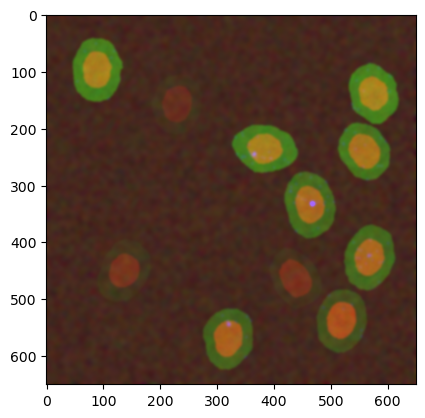

In [106]:
plt.imshow(img[0,:,:,:])

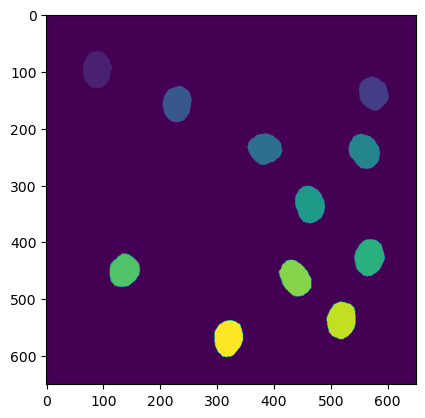

In [98]:
plt.imshow(masks_nuc)

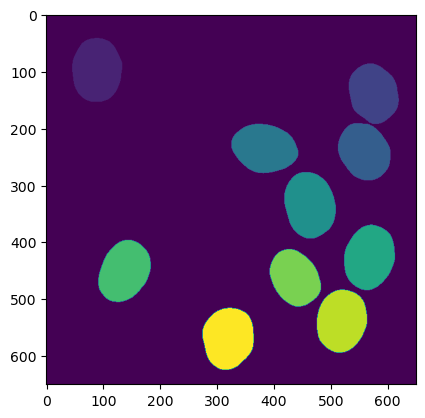

In [99]:
plt.imshow(masks_cyto)

## Plotting over time

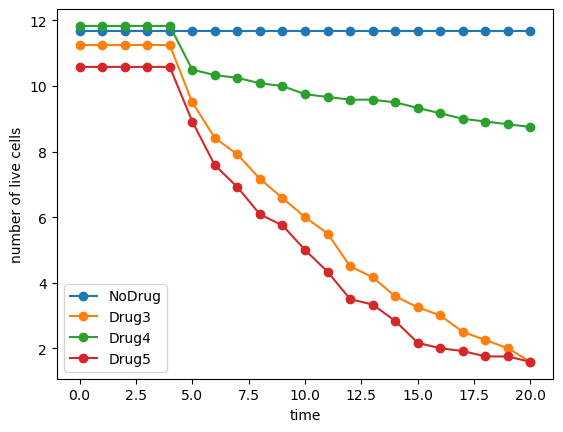

In [100]:
list_vital0 = [df['vitality'] for df in list_df_nodrug]
list_vital3 = [df['vitality'] for df in list_df_drug3]
list_vital4 = [df['vitality'] for df in list_df_drug4]
list_vital5 = [df['vitality'] for df in list_df_drug5]
# list_vital6 = [df['vitality'] for df in list_df_drug6]
plt.plot(np.mean(list_vital0, axis=0), '-o', label='NoDrug')
plt.plot(np.mean(list_vital3, axis=0), '-o', label='Drug3')
plt.plot(np.mean(list_vital4, axis=0), '-o', label='Drug4')
plt.plot(np.mean(list_vital5, axis=0), '-o', label='Drug5')
# plt.plot(np.mean(list_vital6, axis=0), '-o', label='Drug6')
plt.xlabel('time')
plt.ylabel('number of live cells')
plt.legend()
plt.show()

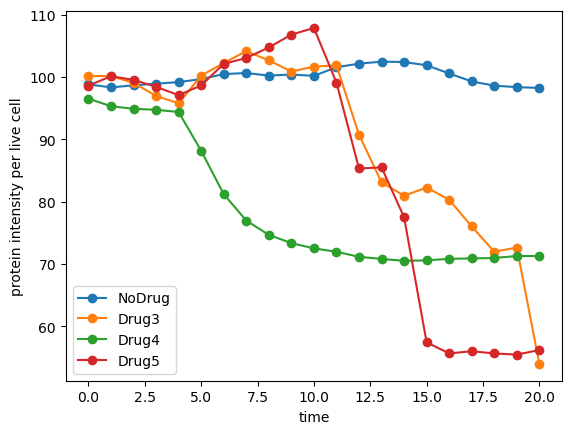

In [102]:
list_pro0 = [df['protein intensity'] for df in list_df_nodrug]
list_pro3 = [df['protein intensity'] for df in list_df_drug3]
list_pro4 = [df['protein intensity'] for df in list_df_drug4]
list_pro5 = [df['protein intensity'] for df in list_df_drug5]
# list_pro3 = [df['protein intensity'] for df in list_df_drug3]
plt.plot(np.mean(list_pro0, axis=0), '-o', label='NoDrug')
plt.plot(np.mean(list_pro3, axis=0), '-o', label='Drug3')
plt.plot(np.mean(list_pro4, axis=0), '-o', label='Drug4')
plt.plot(np.mean(list_pro5, axis=0), '-o', label='Drug5')
# plt.plot(np.mean(list_pro6, axis=0), '-o', label='Drug3')
plt.xlabel('time')
plt.ylabel('protein intensity per live cell')
plt.legend()
plt.show()

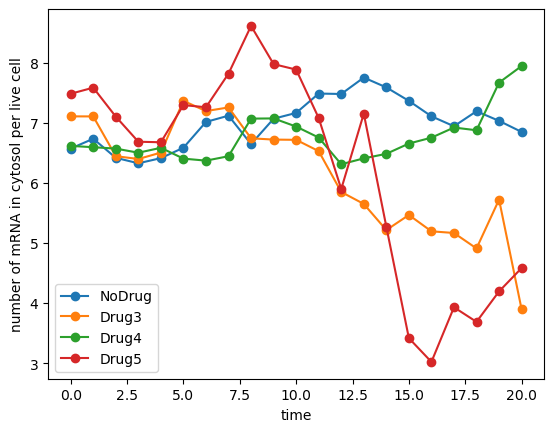

In [103]:
list_cyt0 = [df['mRNA in cytosol'] for df in list_df_nodrug]
list_cyt3 = [df['mRNA in cytosol'] for df in list_df_drug3]
list_cyt4 = [df['mRNA in cytosol'] for df in list_df_drug4]
list_cyt5 = [df['mRNA in cytosol'] for df in list_df_drug5]
# list_cyt6 = [df['mRNA in cytosol'] for df in list_df_drug6]
plt.plot(np.mean(list_cyt0, axis=0), '-o', label='NoDrug')
plt.plot(np.mean(list_cyt3, axis=0), '-o', label='Drug3')
plt.plot(np.mean(list_cyt4, axis=0), '-o', label='Drug4')
plt.plot(np.mean(list_cyt5, axis=0), '-o', label='Drug5')
# plt.plot(np.mean(list_cyt5, axis=0), '-o', label='Drug6')
plt.xlabel('time')
plt.ylabel('number of mRNA in cytosol per live cell')
plt.legend()
plt.show()

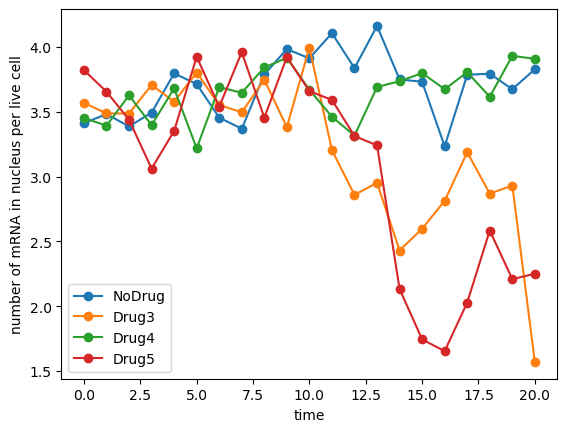

In [105]:
list_nuc0 = [df['mRNA in nucleus'] for df in list_df_nodrug]
list_nuc3 = [df['mRNA in nucleus'] for df in list_df_drug3]
list_nuc4 = [df['mRNA in nucleus'] for df in list_df_drug4]
list_nuc5 = [df['mRNA in nucleus'] for df in list_df_drug5]
# list_nuc6 = [df['mRNA in nucleus'] for df in list_df_drug6]
plt.plot(np.mean(list_nuc0, axis=0), '-o', label='NoDrug')
plt.plot(np.mean(list_nuc3, axis=0), '-o', label='Drug3')
plt.plot(np.mean(list_nuc4, axis=0), '-o', label='Drug4')
plt.plot(np.mean(list_nuc5, axis=0), '-o', label='Drug5')
# plt.plot(np.mean(list_nuc6, axis=0), '-o', label='Drug6')
plt.xlabel('time')
plt.ylabel('number of mRNA in nucleus per live cell')
plt.legend()
plt.show()